In this notebook, I'm going to first download the CIFAR-10 dataset (or read it from cached data) and then train a CNN on it. <br>
Here we imported pytorch libraries which we'll going to use in next cells

In [ ]:
import numpy as np 
import matplotlib.pyplot as plt
import torch
import torchvision
from torchvision import datasets, transforms
from torchvision.ops import MLP
from torch import nn, optim
import cv2
from tqdm import tqdm

Here we set the code runtime env, First we look for CUDA and if it's available we select it as our device, else we choose CPU env.

In [ ]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    print('OK CUDA was avaialbe.')
else:
    device = torch.device('cpu')
print(device)

OK CUDA was avaialbe.
cuda


In this cell, we'ere going to define a list of transforms that we want to apply on our data before training.<br>
Downloaded dataset samples are in form of PIL images, but in order to create torch model over them, we need them in shape of tensors, so the first four transforms are augmentations, First augmentation used to change the color brightness and satur of images, the next one randomly flip the image with probability of 0.5 (expecting to have 50% of images flipped) and the next of randomly flip the image but this time vertically. The last augmentation randomly rotate each image from -10 to +10 degrees. After that we used ToTensor() to convert PIL objects to tensors.<br>
The next transform is going to normalize input images. We define normalization parameters for each channel seperately.<br>
Normalization and Augmentation params are the same as the params used by this repo:<br>
https://github.com/priyavrat-misra/cifar10

In [ ]:
transform = transforms.Compose([
    # Augmentations
    transforms.ColorJitter(brightness=0.25, saturation=0.1),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(10), # -10 to +10 degrees
    
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

Now we're going to download the data (CIFAR10) and sperate it into two parts, train and test.<br>
If a previously downloaded data is avaialable we're gonna use it.<br>
We also run previously defined transforms on our dataset. (ToTensor, Normalize)

In [ ]:
train_path = 'ds/train/'
test_path = 'ds/test/'
print(f'- Downlaoding training set')
dstrain = datasets.CIFAR10(train_path, train=True, download=True, transform=transform)
print(f'- Downloading testing set')
dstest = datasets.CIFAR10(test_path, train=False, download=True, transform=transform)

- Downlaoding training set
Files already downloaded and verified
- Downloading testing set
Files already downloaded and verified


Here in this cell, we're gonna see some basic information about our dataset. It has 50000 training images and 10000 test ones. <br>
Total 60000 samples divided into 10 classes:<br>
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']<br>
Images are 32*32 RGB and for each class we have 6000 samples.<br>
Dataset is sperated in 5 trainig batch and 1 test batch, each containing 10000 images.<br>
Images are not divided between training batches uniformly (which means, one batch may contains more images for one class than the others), But there are exactly 5000 trainig image and 1000 test image for each class.<br>
More information about this dataset here: https://www.cs.toronto.edu/~kriz/cifar.html

In [ ]:
print(dstrain)
print(dstest)
print(len(dstrain.classes))
print(dstrain.classes)

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ds/train/
    Split: Train
    StandardTransform
Transform: Compose(
               ColorJitter(brightness=[0.75, 1.25], contrast=None, saturation=[0.9, 1.1], hue=None)
               RandomHorizontalFlip(p=0.5)
               RandomVerticalFlip(p=0.5)
               RandomRotation(degrees=[-10.0, 10.0], interpolation=nearest, expand=False, fill=0)
               ToTensor()
               Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
           )
Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ds/test/
    Split: Test
    StandardTransform
Transform: Compose(
               ColorJitter(brightness=[0.75, 1.25], contrast=None, saturation=[0.9, 1.1], hue=None)
               RandomHorizontalFlip(p=0.5)
               RandomVerticalFlip(p=0.5)
               RandomRotation(degrees=[-10.0, 10.0], interpolation=nearest, expand=False, fill=0)
               ToTensor()
               Normal

Here we defined a loader which is a wrapper around data that can help us divide data into batches and only load those batches that we need instead of loading the whole dataset into memory. It's saving lots of memory.<br>
Batch Size = 16 (means training would use 16 images loss at each iteration)

In [ ]:
batch = 16
ldtrain = torch.utils.data.DataLoader(dstrain, batch_size=batch, shuffle=True)
ldval = torch.utils.data.DataLoader(dstest, batch_size=batch, shuffle=True)

Now let's show a subset of images, to do so, first we converted train set loaded to a python iterator and get the first iteration value out of it. 

In [ ]:
dataiter = iter(ldtrain)
images ,labels = next(dataiter)

print(images.shape)
print(labels.shape)

torch.Size([16, 3, 32, 32])
torch.Size([16])


Now in this cell, we just printed a batch of the images,<br>
Notice that to do so, we need to move RGB channel to the last axis of tensor<br>
Images may does not look like the original ones, because we normalized then and now we are reversing the normalization. So it may look a bit odd

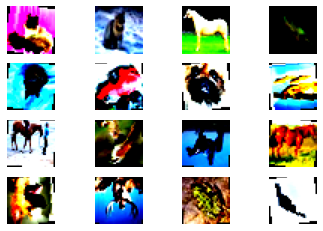

In [ ]:
noi = 4
num_of_images = noi * noi
for index in range(1, num_of_images+1):
    img = images[index-1]
    
    _ = plt.subplot(noi,noi, index)
    _ = plt.axis('off')
    _ = plt.imshow(img.moveaxis(0, -1))

In this cell, we're defining the architecture of CNN model which we are going to use to model our CIFAR10 dataset.

In [ ]:
model = nn.Sequential(
    nn.Conv2d(3, 32, (3,3), (1,1), 'same'),
    nn.ReLU(),
    nn.Conv2d(32, 64, (3,3), (1,1), 'valid'),
    nn.ReLU(),
    nn.MaxPool2d((2,2)),
    nn.Dropout(0.3),
    nn.BatchNorm2d(64),

    nn.Conv2d(64, 128, (3,3), (1,1), 'same'),
    nn.ReLU(),
    nn.Conv2d(128, 256, (3,3), (1,1), 'valid'),
    nn.ReLU(),
    nn.MaxPool2d((2,2)),
    nn.Dropout(0.3),
    nn.BatchNorm2d(256),

    nn.Conv2d(256, 512, (3,3), (1,1), 'same'),
    nn.ReLU(),
    nn.Conv2d(512, 1024, (3,3), (1,1), 'valid'),
    nn.ReLU(),
    nn.MaxPool2d((2,2)),
    nn.Dropout(0.5),
    nn.BatchNorm2d(1024),

    nn.Flatten(),
    nn.Linear(4096, 1024),
    nn.ReLU(),
    nn.Linear(1024, 512),
    nn.ReLU(),
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Dropout(0.5),

    nn.Linear(256, 10)
)

print(model)

Sequential(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (1): ReLU()
  (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=valid)
  (3): ReLU()
  (4): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (5): Dropout(p=0.3, inplace=False)
  (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (8): ReLU()
  (9): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=valid)
  (10): ReLU()
  (11): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (12): Dropout(p=0.3, inplace=False)
  (13): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (14): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (15): ReLU()
  (16): Conv2d(512, 1024, kernel_size=(3, 3), stride=(1, 1), padding=valid)
  (17): ReLU()
  (18): MaxPool2d(kernel_si

binding model object to specified training hardware

In [ ]:
_ = model.to(device)

defining learning rate, number of epochs, validation frequency, optimizer and loss function

In [ ]:
n_epochs = 120
val_freq = 5

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [ ]:
def accuracy(y_pred, y):
    """
    Calculating the accuracy of given batch.
    input(s):
    y_pred (ndarray): predicted logits or the output of the model.
    y (ndarray): labels
    """
    pred_idx = y_pred.max(1, keepdim=True)[1]
    correct = pred_idx.eq(y.view_as(pred_idx)).sum().item()
    return correct / len(y)

In [ ]:
history = dict()
history['train_loss']= list()
history['train_acc']= list()
history['val_loss']= list()
history['val_acc']= list()
for epoch in range(n_epochs):
    running_loss = 0
    running_acc = 0

    model.train()
    for idx, (X, y) in enumerate(tqdm(ldtrain)):
        optimizer.zero_grad()
        X, y = X.to(device), y.to(device)
        y_hat = model(X)
        loss = criterion(y_hat, y)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        running_acc += accuracy(y_hat, y)
    else:
        running_loss = running_loss/ len(ldtrain)
        running_acc = running_acc / len(ldtrain)
        history['train_loss'].append(running_loss)
        history['train_acc'].append(running_acc)
        print(f'Epoch {epoch+1}/{n_epochs} : training loss: {running_loss}, training acc: {running_acc}')




    if epoch% val_freq == val_freq-1:
        running_loss = 0
        running_acc = 0
        model.eval()
        with torch.no_grad():
            for idx, (X, y) in enumerate(tqdm(ldval)):
                X, y = X.to(device), y.to(device) 
                y_hat = model(X)
                loss = criterion(y_hat, y)

                running_loss += loss.item()
                running_acc += accuracy(y_hat, y)
            else:
                running_loss = running_loss/ len(ldval)
                running_acc = running_acc / len(ldval)
                history['val_loss'].append(running_loss)
                history['val_acc'].append(running_acc)
                print(f'Epoch {epoch+1}/{n_epochs} : validation loss: {running_loss}, validation acc: {running_acc}')

100%|██████████| 3125/3125 [01:01<00:00, 51.03it/s]


Epoch 1/120 : training loss: 1.8717748875045777, training acc: 0.28006


100%|██████████| 3125/3125 [01:01<00:00, 50.71it/s]


Epoch 2/120 : training loss: 1.4815876301574706, training acc: 0.44876


100%|██████████| 3125/3125 [01:00<00:00, 51.48it/s]


Epoch 3/120 : training loss: 1.2898888570785523, training acc: 0.53534


100%|██████████| 3125/3125 [01:01<00:00, 51.22it/s]


Epoch 4/120 : training loss: 1.183610595703125, training acc: 0.57728


100%|██████████| 3125/3125 [01:00<00:00, 51.55it/s]


Epoch 5/120 : training loss: 1.1187395043563844, training acc: 0.60432


100%|██████████| 625/625 [00:07<00:00, 79.33it/s]


Epoch 5/120 : validation loss: 0.9709900499343872, validation acc: 0.6471


100%|██████████| 3125/3125 [01:00<00:00, 51.46it/s]


Epoch 6/120 : training loss: 1.0613695919704438, training acc: 0.62656


100%|██████████| 3125/3125 [01:01<00:00, 51.17it/s]


Epoch 7/120 : training loss: 1.019048554353714, training acc: 0.63966


100%|██████████| 3125/3125 [01:00<00:00, 51.68it/s]


Epoch 8/120 : training loss: 0.9854597937488556, training acc: 0.65158


100%|██████████| 3125/3125 [01:00<00:00, 51.44it/s]


Epoch 9/120 : training loss: 0.9520665662050247, training acc: 0.66326


100%|██████████| 3125/3125 [01:00<00:00, 51.77it/s]


Epoch 10/120 : training loss: 0.9222263947725297, training acc: 0.6759


100%|██████████| 625/625 [00:07<00:00, 81.05it/s]


Epoch 10/120 : validation loss: 0.7838578861951828, validation acc: 0.7224


100%|██████████| 3125/3125 [01:01<00:00, 51.06it/s]


Epoch 11/120 : training loss: 0.8982151521873474, training acc: 0.6868


100%|██████████| 3125/3125 [01:00<00:00, 51.61it/s]


Epoch 12/120 : training loss: 0.8784777405118942, training acc: 0.69422


100%|██████████| 3125/3125 [01:00<00:00, 51.77it/s]


Epoch 13/120 : training loss: 0.8607497288846969, training acc: 0.7004


100%|██████████| 3125/3125 [01:00<00:00, 51.83it/s]


Epoch 14/120 : training loss: 0.8447387748003006, training acc: 0.70504


100%|██████████| 3125/3125 [01:00<00:00, 51.36it/s]


Epoch 15/120 : training loss: 0.8250960269927978, training acc: 0.71024


100%|██████████| 625/625 [00:07<00:00, 80.19it/s]


Epoch 15/120 : validation loss: 0.7024889936447144, validation acc: 0.7568


100%|██████████| 3125/3125 [01:00<00:00, 51.49it/s]


Epoch 16/120 : training loss: 0.8064198992490769, training acc: 0.71892


100%|██████████| 3125/3125 [01:00<00:00, 51.80it/s]


Epoch 17/120 : training loss: 0.7911821735715866, training acc: 0.7275


100%|██████████| 3125/3125 [01:00<00:00, 51.99it/s]


Epoch 18/120 : training loss: 0.7924883316993714, training acc: 0.72792


100%|██████████| 3125/3125 [01:00<00:00, 51.54it/s]


Epoch 19/120 : training loss: 0.76293838180542, training acc: 0.73538


100%|██████████| 3125/3125 [01:00<00:00, 51.87it/s]


Epoch 20/120 : training loss: 0.745586276640892, training acc: 0.74166


100%|██████████| 625/625 [00:07<00:00, 81.59it/s]


Epoch 20/120 : validation loss: 0.6405545487523079, validation acc: 0.7788


100%|██████████| 3125/3125 [01:00<00:00, 51.84it/s]


Epoch 21/120 : training loss: 0.7353031726765633, training acc: 0.74516


100%|██████████| 3125/3125 [00:59<00:00, 52.13it/s]


Epoch 22/120 : training loss: 0.7192403274917603, training acc: 0.753


100%|██████████| 3125/3125 [01:00<00:00, 51.33it/s]


Epoch 23/120 : training loss: 0.7087274147844315, training acc: 0.75638


100%|██████████| 3125/3125 [01:00<00:00, 51.28it/s]


Epoch 24/120 : training loss: 0.69727226978302, training acc: 0.76192


100%|██████████| 3125/3125 [01:01<00:00, 51.21it/s]


Epoch 25/120 : training loss: 0.6803521167778969, training acc: 0.76546


100%|██████████| 625/625 [00:07<00:00, 79.62it/s]


Epoch 25/120 : validation loss: 0.5716884410053492, validation acc: 0.8036


100%|██████████| 3125/3125 [01:01<00:00, 51.15it/s]


Epoch 26/120 : training loss: 0.6682750816988945, training acc: 0.77204


100%|██████████| 3125/3125 [01:01<00:00, 50.80it/s]


Epoch 27/120 : training loss: 0.6594763303887844, training acc: 0.7737


100%|██████████| 3125/3125 [01:00<00:00, 51.26it/s]


Epoch 28/120 : training loss: 0.6541083986711502, training acc: 0.77584


100%|██████████| 3125/3125 [01:00<00:00, 51.60it/s]


Epoch 29/120 : training loss: 0.6397739347529411, training acc: 0.77844


100%|██████████| 3125/3125 [01:00<00:00, 51.33it/s]


Epoch 30/120 : training loss: 0.6360513084864616, training acc: 0.7813


100%|██████████| 625/625 [00:07<00:00, 79.31it/s]


Epoch 30/120 : validation loss: 0.5317255146026612, validation acc: 0.816


100%|██████████| 3125/3125 [01:01<00:00, 51.04it/s]


Epoch 31/120 : training loss: 0.6282627709245682, training acc: 0.7834


100%|██████████| 3125/3125 [01:01<00:00, 51.23it/s]


Epoch 32/120 : training loss: 0.6184628076219558, training acc: 0.78912


100%|██████████| 3125/3125 [01:00<00:00, 51.53it/s]


Epoch 33/120 : training loss: 0.6098436608529091, training acc: 0.7914


100%|██████████| 3125/3125 [01:00<00:00, 51.43it/s]


Epoch 34/120 : training loss: 0.5989935370063781, training acc: 0.7941


100%|██████████| 3125/3125 [01:00<00:00, 51.45it/s]


Epoch 35/120 : training loss: 0.5899412306189538, training acc: 0.79954


100%|██████████| 625/625 [00:07<00:00, 79.77it/s]


Epoch 35/120 : validation loss: 0.5029832376897335, validation acc: 0.8314


100%|██████████| 3125/3125 [01:00<00:00, 51.27it/s]


Epoch 36/120 : training loss: 0.5852787917542458, training acc: 0.79858


100%|██████████| 3125/3125 [01:00<00:00, 51.55it/s]


Epoch 37/120 : training loss: 0.5758032787299157, training acc: 0.80192


100%|██████████| 3125/3125 [01:00<00:00, 51.26it/s]


Epoch 38/120 : training loss: 0.5687424268949032, training acc: 0.80436


100%|██████████| 3125/3125 [01:00<00:00, 51.48it/s]


Epoch 39/120 : training loss: 0.5580765583968162, training acc: 0.80942


100%|██████████| 3125/3125 [01:00<00:00, 51.51it/s]


Epoch 40/120 : training loss: 0.5610435303735734, training acc: 0.80506


100%|██████████| 625/625 [00:07<00:00, 80.52it/s]


Epoch 40/120 : validation loss: 0.4991447038054466, validation acc: 0.8303


100%|██████████| 3125/3125 [01:01<00:00, 51.13it/s]


Epoch 41/120 : training loss: 0.5478630625128746, training acc: 0.81098


100%|██████████| 3125/3125 [01:00<00:00, 51.56it/s]


Epoch 42/120 : training loss: 0.5409815447300672, training acc: 0.81408


100%|██████████| 3125/3125 [01:00<00:00, 51.54it/s]


Epoch 43/120 : training loss: 0.5347534406018257, training acc: 0.81598


100%|██████████| 3125/3125 [01:00<00:00, 51.40it/s]


Epoch 44/120 : training loss: 0.5345358253479003, training acc: 0.81708


100%|██████████| 3125/3125 [01:00<00:00, 51.43it/s]


Epoch 45/120 : training loss: 0.522783634428978, training acc: 0.82052


100%|██████████| 625/625 [00:07<00:00, 80.77it/s]


Epoch 45/120 : validation loss: 0.4698970142990351, validation acc: 0.8374


100%|██████████| 3125/3125 [01:01<00:00, 50.95it/s]


Epoch 46/120 : training loss: 0.5201088239347935, training acc: 0.8229


100%|██████████| 3125/3125 [01:00<00:00, 51.29it/s]


Epoch 47/120 : training loss: 0.5169783531832695, training acc: 0.82364


100%|██████████| 3125/3125 [01:06<00:00, 47.34it/s]


Epoch 48/120 : training loss: 0.5045148191046714, training acc: 0.82738


100%|██████████| 3125/3125 [01:01<00:00, 51.11it/s]


Epoch 49/120 : training loss: 0.497011492241621, training acc: 0.82968


100%|██████████| 3125/3125 [01:00<00:00, 51.46it/s]


Epoch 50/120 : training loss: 0.4976445816612244, training acc: 0.82982


100%|██████████| 625/625 [00:07<00:00, 79.34it/s]


Epoch 50/120 : validation loss: 0.46028502460122106, validation acc: 0.8402


100%|██████████| 3125/3125 [01:01<00:00, 50.94it/s]


Epoch 51/120 : training loss: 0.49085877922594545, training acc: 0.83194


100%|██████████| 3125/3125 [01:00<00:00, 51.41it/s]


Epoch 52/120 : training loss: 0.4877441441953182, training acc: 0.83092


100%|██████████| 3125/3125 [01:00<00:00, 51.58it/s]


Epoch 53/120 : training loss: 0.48490680951654913, training acc: 0.8346


100%|██████████| 3125/3125 [01:00<00:00, 51.44it/s]


Epoch 54/120 : training loss: 0.475346433109045, training acc: 0.8371


100%|██████████| 3125/3125 [01:00<00:00, 51.38it/s]


Epoch 55/120 : training loss: 0.47318909950971605, training acc: 0.83734


100%|██████████| 625/625 [00:07<00:00, 80.84it/s]


Epoch 55/120 : validation loss: 0.4463889166265726, validation acc: 0.8483


100%|██████████| 3125/3125 [01:00<00:00, 51.24it/s]


Epoch 56/120 : training loss: 0.4734155649238825, training acc: 0.83662


100%|██████████| 3125/3125 [01:00<00:00, 51.58it/s]


Epoch 57/120 : training loss: 0.4664209389388561, training acc: 0.84112


100%|██████████| 3125/3125 [01:00<00:00, 51.74it/s]


Epoch 58/120 : training loss: 0.45417058189988135, training acc: 0.84408


100%|██████████| 3125/3125 [01:00<00:00, 51.71it/s]


Epoch 59/120 : training loss: 0.4566297185206413, training acc: 0.84208


100%|██████████| 3125/3125 [01:00<00:00, 51.45it/s]


Epoch 60/120 : training loss: 0.4532585843414068, training acc: 0.84556


100%|██████████| 625/625 [00:07<00:00, 78.71it/s]


Epoch 60/120 : validation loss: 0.43521105468273164, validation acc: 0.8518


100%|██████████| 3125/3125 [01:01<00:00, 50.96it/s]


Epoch 61/120 : training loss: 0.45022339035749437, training acc: 0.84542


100%|██████████| 3125/3125 [01:00<00:00, 51.65it/s]


Epoch 62/120 : training loss: 0.4408859526181221, training acc: 0.84816


100%|██████████| 3125/3125 [01:00<00:00, 51.76it/s]


Epoch 63/120 : training loss: 0.44312464177459476, training acc: 0.84826


100%|██████████| 3125/3125 [01:00<00:00, 51.44it/s]


Epoch 64/120 : training loss: 0.43851447939395904, training acc: 0.85062


100%|██████████| 3125/3125 [01:00<00:00, 51.48it/s]


Epoch 65/120 : training loss: 0.43441829188644887, training acc: 0.85102


100%|██████████| 625/625 [00:07<00:00, 80.99it/s]


Epoch 65/120 : validation loss: 0.4214606140375137, validation acc: 0.8565


100%|██████████| 3125/3125 [01:01<00:00, 51.22it/s]


Epoch 66/120 : training loss: 0.4269942926609516, training acc: 0.8537


100%|██████████| 3125/3125 [01:00<00:00, 51.74it/s]


Epoch 67/120 : training loss: 0.42525112366080287, training acc: 0.85424


100%|██████████| 3125/3125 [01:00<00:00, 51.74it/s]


Epoch 68/120 : training loss: 0.4218317748439312, training acc: 0.8549


100%|██████████| 3125/3125 [01:00<00:00, 51.67it/s]


Epoch 69/120 : training loss: 0.42102894777715205, training acc: 0.85532


100%|██████████| 3125/3125 [01:00<00:00, 51.73it/s]


Epoch 70/120 : training loss: 0.41553102197408676, training acc: 0.85908


100%|██████████| 625/625 [00:07<00:00, 80.65it/s]


Epoch 70/120 : validation loss: 0.41764556222259996, validation acc: 0.8599


100%|██████████| 3125/3125 [01:01<00:00, 51.22it/s]


Epoch 71/120 : training loss: 0.41127025804281236, training acc: 0.85788


100%|██████████| 3125/3125 [01:00<00:00, 51.78it/s]


Epoch 72/120 : training loss: 0.40687150805354116, training acc: 0.8613


100%|██████████| 3125/3125 [01:00<00:00, 51.68it/s]


Epoch 73/120 : training loss: 0.40484542872577906, training acc: 0.86014


100%|██████████| 3125/3125 [01:00<00:00, 51.84it/s]


Epoch 74/120 : training loss: 0.396338417211473, training acc: 0.86308


100%|██████████| 3125/3125 [01:00<00:00, 51.71it/s]


Epoch 75/120 : training loss: 0.40262111372947695, training acc: 0.86156


100%|██████████| 625/625 [00:07<00:00, 81.38it/s]


Epoch 75/120 : validation loss: 0.41455142719596627, validation acc: 0.8635


100%|██████████| 3125/3125 [01:00<00:00, 51.78it/s]


Epoch 76/120 : training loss: 0.400631881698966, training acc: 0.86006


100%|██████████| 3125/3125 [01:00<00:00, 51.48it/s]


Epoch 77/120 : training loss: 0.3971544981974363, training acc: 0.86152


100%|██████████| 3125/3125 [01:00<00:00, 51.83it/s]


Epoch 78/120 : training loss: 0.3899694741290808, training acc: 0.86624


100%|██████████| 3125/3125 [01:00<00:00, 51.89it/s]


Epoch 79/120 : training loss: 0.390361833434701, training acc: 0.86578


100%|██████████| 3125/3125 [01:00<00:00, 51.75it/s]


Epoch 80/120 : training loss: 0.38332527495205404, training acc: 0.86836


100%|██████████| 625/625 [00:07<00:00, 79.51it/s]


Epoch 80/120 : validation loss: 0.41966255303472283, validation acc: 0.8624


100%|██████████| 3125/3125 [01:00<00:00, 51.47it/s]


Epoch 81/120 : training loss: 0.389618456556499, training acc: 0.86444


100%|██████████| 3125/3125 [01:01<00:00, 51.13it/s]


Epoch 82/120 : training loss: 0.3798802386504412, training acc: 0.86908


100%|██████████| 3125/3125 [01:00<00:00, 51.50it/s]


Epoch 83/120 : training loss: 0.3728792593669891, training acc: 0.87244


100%|██████████| 3125/3125 [01:00<00:00, 51.39it/s]


Epoch 84/120 : training loss: 0.37307502515971663, training acc: 0.87148


100%|██████████| 3125/3125 [01:00<00:00, 51.63it/s]


Epoch 85/120 : training loss: 0.372117895860672, training acc: 0.87158


100%|██████████| 625/625 [00:07<00:00, 80.75it/s]


Epoch 85/120 : validation loss: 0.40461435391008854, validation acc: 0.8609


100%|██████████| 3125/3125 [01:00<00:00, 51.39it/s]


Epoch 86/120 : training loss: 0.3706666943013668, training acc: 0.87206


100%|██████████| 3125/3125 [01:01<00:00, 51.05it/s]


Epoch 87/120 : training loss: 0.36380596235632895, training acc: 0.87416


100%|██████████| 3125/3125 [01:00<00:00, 51.28it/s]


Epoch 88/120 : training loss: 0.36867857009887695, training acc: 0.87308


100%|██████████| 3125/3125 [01:00<00:00, 51.52it/s]


Epoch 89/120 : training loss: 0.3684717895680666, training acc: 0.87356


100%|██████████| 3125/3125 [01:00<00:00, 51.40it/s]


Epoch 90/120 : training loss: 0.35912409161657094, training acc: 0.87564


100%|██████████| 625/625 [00:07<00:00, 80.76it/s]


Epoch 90/120 : validation loss: 0.4040636378109455, validation acc: 0.8653


100%|██████████| 3125/3125 [01:01<00:00, 51.22it/s]


Epoch 91/120 : training loss: 0.3564719606912136, training acc: 0.87686


100%|██████████| 3125/3125 [01:01<00:00, 51.21it/s]


Epoch 92/120 : training loss: 0.3538398693537712, training acc: 0.87872


100%|██████████| 3125/3125 [01:00<00:00, 51.43it/s]


Epoch 93/120 : training loss: 0.35478450344130397, training acc: 0.87792


100%|██████████| 3125/3125 [01:00<00:00, 51.28it/s]


Epoch 94/120 : training loss: 0.3511214407154918, training acc: 0.87868


100%|██████████| 3125/3125 [01:00<00:00, 51.52it/s]


Epoch 95/120 : training loss: 0.34677274665653707, training acc: 0.881


100%|██████████| 625/625 [00:07<00:00, 80.39it/s]


Epoch 95/120 : validation loss: 0.3926163560733199, validation acc: 0.8701


100%|██████████| 3125/3125 [01:00<00:00, 51.36it/s]


Epoch 96/120 : training loss: 0.34043629333615305, training acc: 0.8834


100%|██████████| 3125/3125 [01:01<00:00, 50.89it/s]


Epoch 97/120 : training loss: 0.3458393235178292, training acc: 0.88088


100%|██████████| 3125/3125 [01:00<00:00, 51.52it/s]


Epoch 98/120 : training loss: 0.33688741921842097, training acc: 0.88336


100%|██████████| 3125/3125 [01:00<00:00, 51.52it/s]


Epoch 99/120 : training loss: 0.34099794438660147, training acc: 0.88134


100%|██████████| 3125/3125 [01:01<00:00, 51.19it/s]


Epoch 100/120 : training loss: 0.33602031556218864, training acc: 0.88456


100%|██████████| 625/625 [00:07<00:00, 79.03it/s]


Epoch 100/120 : validation loss: 0.38634078414738177, validation acc: 0.871


100%|██████████| 3125/3125 [01:00<00:00, 51.33it/s]


Epoch 101/120 : training loss: 0.33571198242723943, training acc: 0.88384


100%|██████████| 3125/3125 [01:01<00:00, 51.02it/s]


Epoch 102/120 : training loss: 0.3334996565711498, training acc: 0.88414


100%|██████████| 3125/3125 [01:01<00:00, 51.23it/s]


Epoch 103/120 : training loss: 0.3269099038337171, training acc: 0.88736


100%|██████████| 3125/3125 [01:00<00:00, 51.37it/s]


Epoch 104/120 : training loss: 0.33061886723726985, training acc: 0.88484


100%|██████████| 3125/3125 [01:00<00:00, 51.60it/s]


Epoch 105/120 : training loss: 0.32723812132686375, training acc: 0.88698


100%|██████████| 625/625 [00:07<00:00, 79.91it/s]


Epoch 105/120 : validation loss: 0.39120971048958597, validation acc: 0.8719


100%|██████████| 3125/3125 [01:00<00:00, 51.57it/s]


Epoch 106/120 : training loss: 0.32801792586609724, training acc: 0.88734


100%|██████████| 3125/3125 [01:01<00:00, 50.95it/s]


Epoch 107/120 : training loss: 0.32008736142516137, training acc: 0.88932


100%|██████████| 3125/3125 [01:00<00:00, 51.42it/s]


Epoch 108/120 : training loss: 0.31658917421013116, training acc: 0.89156


100%|██████████| 3125/3125 [01:00<00:00, 51.51it/s]


Epoch 109/120 : training loss: 0.31725926555104556, training acc: 0.8908


100%|██████████| 3125/3125 [01:00<00:00, 51.32it/s]


Epoch 110/120 : training loss: 0.3155793676686287, training acc: 0.8909


100%|██████████| 625/625 [00:07<00:00, 79.46it/s]


Epoch 110/120 : validation loss: 0.3790425733178854, validation acc: 0.8744


100%|██████████| 3125/3125 [01:00<00:00, 51.42it/s]


Epoch 111/120 : training loss: 0.3188111760228872, training acc: 0.88988


100%|██████████| 3125/3125 [01:01<00:00, 51.07it/s]


Epoch 112/120 : training loss: 0.31397410450249913, training acc: 0.89226


100%|██████████| 3125/3125 [01:00<00:00, 51.57it/s]


Epoch 113/120 : training loss: 0.30790144770510497, training acc: 0.89432


100%|██████████| 3125/3125 [01:00<00:00, 51.78it/s]


Epoch 114/120 : training loss: 0.3104498194849491, training acc: 0.89176


100%|██████████| 3125/3125 [01:00<00:00, 51.39it/s]


Epoch 115/120 : training loss: 0.3073707814462483, training acc: 0.89442


100%|██████████| 625/625 [00:07<00:00, 80.46it/s]


Epoch 115/120 : validation loss: 0.38189746932685376, validation acc: 0.8787


100%|██████████| 3125/3125 [01:00<00:00, 51.45it/s]


Epoch 116/120 : training loss: 0.3045772161576152, training acc: 0.89508


100%|██████████| 3125/3125 [01:01<00:00, 50.95it/s]


Epoch 117/120 : training loss: 0.30660478523015977, training acc: 0.89454


100%|██████████| 3125/3125 [01:00<00:00, 51.42it/s]


Epoch 118/120 : training loss: 0.30338046187229456, training acc: 0.89614


100%|██████████| 3125/3125 [01:00<00:00, 51.33it/s]


Epoch 119/120 : training loss: 0.29660047693639996, training acc: 0.8964


100%|██████████| 3125/3125 [01:00<00:00, 51.42it/s]


Epoch 120/120 : training loss: 0.29373739149183037, training acc: 0.8975


100%|██████████| 625/625 [00:07<00:00, 81.01it/s]

Epoch 120/120 : validation loss: 0.39741017513275145, validation acc: 0.8763


Text(0, 0.5, 'acc')

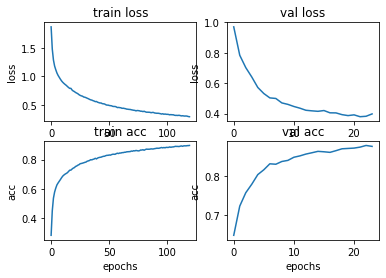

In [ ]:
plt.subplot(2,2,1)
plt.title('train loss')
plt.plot(history['train_loss'])
plt.xlabel("epochs")
plt.ylabel("loss")
#plt.show()

plt.subplot(2,2,2)
plt.title('val loss')
plt.plot(history['val_loss'])
plt.xlabel("epochs")
plt.ylabel("loss")
#plt.show()

plt.subplot(2,2,3)
plt.title('train acc')
plt.plot(history['train_acc'])
plt.xlabel("epochs")
plt.ylabel("acc")
#plt.show()

plt.subplot(2,2,4)
plt.title('val acc')
plt.plot(history['val_acc'])
plt.xlabel("epochs")
plt.ylabel("acc")
#plt.show()

In [ ]:
from google.colab import files

torch.save(model.state_dict(), 'checkpoint.pth')

# download checkpoint file
files.download('checkpoint.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>